In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 7.0MB/s 


In [6]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflowjs as tfjs
from spacy.lang.en import English
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [7]:
# Load and Preprocessing Data
## Load Data
data_dir = "/content/gdrive/MyDrive/Project1/data/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()

def preprocess_text_with_line_numbers(filename):
    input_line = get_lines(filename) #get all file from file name
    abstract_line = "" #create an empty abstract
    abstract_samples = [] #create an empty list of abstracts

    # Loop through each line in target file
    for line in input_line:
        if line.startswith("###"):# check to see if line is an ID lines
            abstract_id = line
            abstract_lines = "" # reset abtracts string
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
    return abstract_samples


# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
data_dir

'/content/gdrive/MyDrive/Project1/data/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [9]:
## get data samples
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
# print(len(train_samples))

In [10]:
##v Create train_df
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)


In [11]:
## Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist() 

In [12]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [13]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [14]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


In [15]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [16]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately


In [17]:
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))

##
alphabet = string.ascii_lowercase + string.digits + string.punctuation
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,
                              name="char_embed")


In [ ]:
# Create a model
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
def get_model():
    # 1. Token inputs
    token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
    token_embeddings = tf_hub_embedding_layer(token_inputs)
    token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs,
                                outputs=token_embeddings)

    # 2. Char inputs
    char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embed(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
    char_model = tf.keras.Model(inputs=char_inputs,
                                outputs=char_bi_lstm)

    # 3. Line numbers inputs
    line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
    x = layers.Dense(32, activation="relu")(line_number_inputs)
    line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                        outputs=x)

    # 4. Total lines inputs
    total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
    y = layers.Dense(32, activation="relu")(total_lines_inputs)
    total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                        outputs=y)

    # 5. Combine token and char embeddings into a hybrid embedding
    combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
    z = layers.Dense(256, activation="relu")(combined_embeddings)
    z = layers.Dropout(0.5)(z)

    # 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
    z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

    # 7. Create output layer
    output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

    # 8. Put together model
    model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output_layer)


    return model


In [ ]:
## Train Model
model = get_model()

# Compile token, char, positional embedding model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the token, char and positional embedding model
history_model = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=len(train_pos_char_token_dataset),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=len(val_pos_char_token_dataset))

Epoch 1/3
5627/5627 [==============================] - 268s 46ms/step - loss: 0.9725 - accuracy: 0.8121 - val_loss: 0.9279 - val_accuracy: 0.8411
Epoch 2/3
5627/5627 [==============================] - 258s 46ms/step - loss: 0.9358 - accuracy: 0.8406 - val_loss: 0.9190 - val_accuracy: 0.8484
Epoch 3/3
5627/5627 [==============================] - 259s 46ms/step - loss: 0.9285 - accuracy: 0.8458 - val_loss: 0.9126 - val_accuracy: 0.8528


In [ ]:
## Save models
model.save('/content/gdrive/MyDrive/Project1/models/project1_model')



INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Project1/models/project1_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Project1/models/project1_model/assets


In [ ]:
model.save_weights('/content/gdrive/MyDrive/Project1/models/jsmodel/project1_model_weights')

In [18]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

model_path = "/content/gdrive/MyDrive/Project1/models/project1_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path,
                                          custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                                          "KerasLayer": hub.KerasLayer}) # required for token embedding

In [20]:
from sklearn.preprocessing import LabelEncoder
def get_pred(filename):
  with open(filename, 'r') as f:
    example_abstracts = f.read()
  
  example_abstracts = example_abstracts.split( sep = '.')
  abstract_lines = []
  for sentence in example_abstracts:
    sentence += '.'
    abstract_lines.append(sentence)
  abstract_lines.remove('.')


  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Go through each line in abstract and create a list of dictionaries containing features for each line
  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
  

  # Get all line_number values from sample abstract
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 


  # Get all total_lines values from sample abstract
  test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

  # Split abstract lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]


  # Make predictions on sample abstract features
  %%time
  test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
  

  # Extract labels ("target" columns) and encode them into integers 
  label_encoder = LabelEncoder()
  train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
  val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
  test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

  test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
  test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

  # Visualize abstract lines and predicted sequence labels
  for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

In [21]:
txt_pred1 = '/content/gdrive/MyDrive/Project1/data/pred_data/pred1.txt'

In [20]:
get_pred(txt_pred1)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 7.15 µs
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS:  Participants were randomly assigned to treatment or wait-list conditions.
METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS:  Standardized effect size estimates were primarily in the medium and large 

In [22]:
txt_pred2 = '/content/gdrive/MyDrive/Project1/data/pred_data/pred2.txt'

In [23]:
get_pred(txt_pred2)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
BACKGROUND: Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.
BACKGROUND:  Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.
BACKGROUND:  There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness.
METHODS:  This review provides an overview of the nutritional psychiatry field.
METHODS:  It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendati

In [23]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [27]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 19s 20ms/step


In [61]:
len(train_df['target'])

180040

In [80]:
from collections import Counter
i = 0
for f in test_df['target']:
  if Counter(f) == Counter("RESULTS"):
    i = i + 1
i

9713

In [58]:
string1, string2 = "abc def ghi", "def ghi abc"
from collections import Counter
Counter(string1) == Counter(string2)

True

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cfn_matrix = confusion_matrix(test_labels_encoded, test_preds)
print(classification_report (test_labels_encoded, test_preds))
print(cfn_matrix)

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      3621
           1       0.89      0.83      0.86      4571
           2       0.87      0.91      0.89      9897
           3       0.78      0.51      0.62      2333
           4       0.86      0.89      0.87      9713

    accuracy                           0.85     30135
   macro avg       0.83      0.79      0.80     30135
weighted avg       0.85      0.85      0.84     30135

[[2847   80  360  312   22]
 [  28 3816   27    0  700]
 [  68   94 8998   24  713]
 [ 909    0  219 1196    9]
 [  11  287  736    3 8676]]


In [75]:
for i in range(5):
  print(sum(cfn_matrix[i]))

3621
4571
9897
2333
9713


In [3]:
print(2847/3621)
print(3816/4571)
print(8998/9897)
print(1196/2333)
print(8676/9713)

0.7862468931234465
0.8348282651498578
0.9091643932504799
0.5126446635233605
0.89323586945331


In [93]:
label = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS' ]

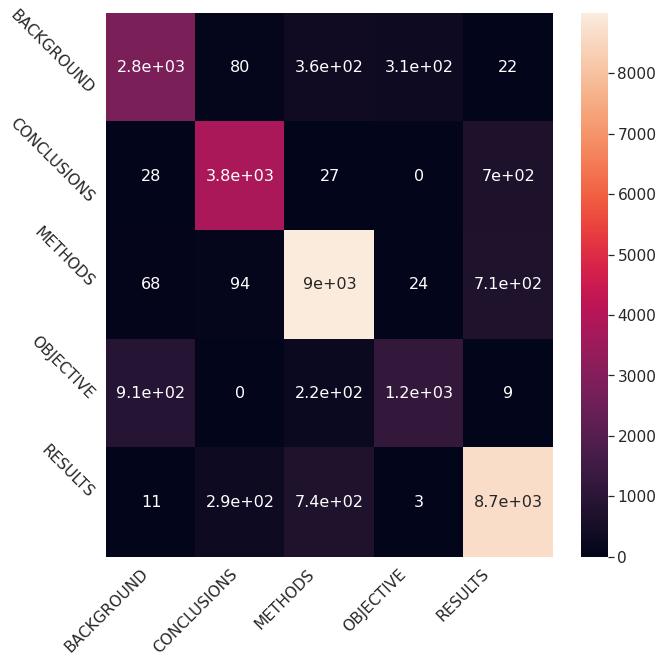

In [95]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cfn  = pd.DataFrame(cfn_matrix, range(5), range(5))
plt.figure(figsize = (10,10))
sn.set(font_scale = 1.4 )
sn.heatmap(df_cfn, annot = True, annot_kws={"size": 16})
tick_marks = np.arange(len(label))
plt.xticks(tick_marks, label, rotation =45)
plt.yticks(tick_marks, label, rotation = -45)
plt.show()